In [3]:
# Load Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

sns.set(style='whitegrid')

In [4]:
# Upload the Datasets
from google.colab import files
uploaded = files.upload()

Saving fear_greed_index.csv to fear_greed_index.csv
Saving hyperliquid_trades.csv to hyperliquid_trades.csv


In [5]:
trader_df = pd.read_csv('hyperliquid_trades.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')


In [6]:
# Preprocess Timestamps
trader_df['Datetime'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')
sentiment_df['Datetime'] = pd.to_datetime(sentiment_df['timestamp'], unit='s')
trader_df['Date'] = trader_df['Datetime'].dt.date
sentiment_df['Date'] = sentiment_df['Datetime'].dt.date

In [7]:
# Merge datasets on date
merged_df = pd.merge(trader_df, sentiment_df[['Date', 'classification']], on='Date', how='left')

# Preview result
display(merged_df.head())

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Datetime,Date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-10-27 03:33:20,2024-10-27,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-10-27 03:33:20,2024-10-27,Greed


In [8]:
# Merge datasets on date
merged_df = pd.merge(trader_df, sentiment_df[['Date', 'classification']], on='Date', how='left')

In [9]:
print(merged_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'Datetime', 'Date', 'classification'],
      dtype='object')


In [36]:
# Calculate performance metrics to ensure pnl_std is present
performance = merged_df.groupby(['Account', 'classification']).agg(
    total_trades=('Trade ID', 'count'),
    avg_pnl=('Closed PnL', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    win_rate=('Closed PnL', lambda x: np.mean(x > 0)),
    trading_days=('Date', pd.Series.nunique),
    avg_fee=('Fee', 'mean'),
    max_drawdown=('Closed PnL', 'min'),
    pnl_std=('Closed PnL', 'std')
).reset_index()

# Compute Sharpe Ratio & Rank Traders
performance['sharpe_ratio'] = performance['avg_pnl'] / performance['pnl_std']
performance.replace([np.inf, -np.inf], np.nan, inplace=True)
performance['pnl_rank'] = performance.groupby('classification')['total_pnl'].rank(ascending=False)
performance['sharpe_rank'] = performance.groupby('classification')['sharpe_ratio'].rank(ascending=False)
performance.drop(columns=['pnl_std'], inplace=True)

display(performance.head())

,Account,classification,total_trades,avg_pnl,total_pnl,win_rate,trading_days,avg_fee,max_drawdown,sharpe_ratio,pnl_rank,sharpe_rank
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,3356,574.414696,1.927736e+06,0.405542,1,1.874975,-19841.24014,0.127386,1.0,17.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,462,-708.887230,-3.275059e+05,0.025974,1,2.408865,-117990.10410,-0.123619,29.0,27.0
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Fear,3533,4.839719,1.709873e+04,0.435041,1,0.471247,-6820.76955,0.027366,26.0,28.0
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Greed,320,64.398269,2.060745e+04,0.531250,1,0.631772,0.00000,0.300918,19.0,10.0
4,0x271b280974205ca63b716753467d5a371de622ab,Fear,1136,26.382859,2.997093e+04,0.430458,1,3.207920,-122.02974,0.238008,22.0,6.0


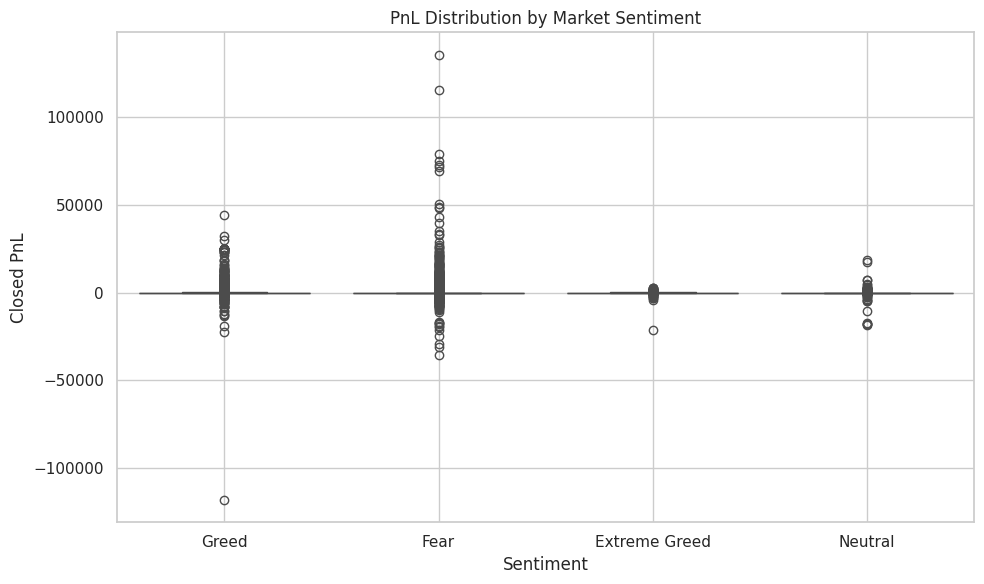

In [12]:
# Visualize PnL by Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='classification', y='Closed PnL')
plt.title("PnL Distribution by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

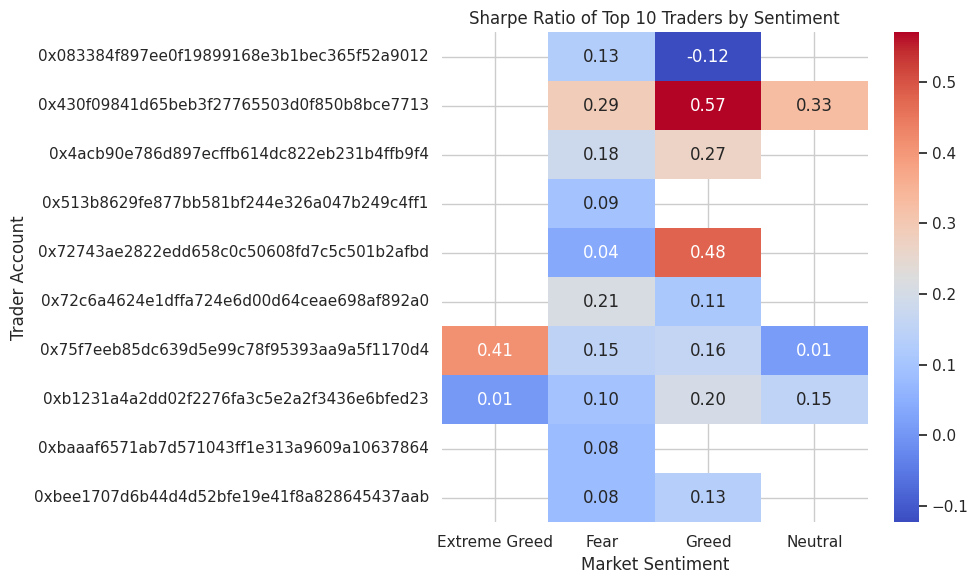

In [13]:
# Heatmap - Sharpe Ratio of Top 10 Traders
top_traders = performance.groupby('Account')['total_pnl'].sum().nlargest(10).index
heatmap_data = performance[performance['Account'].isin(top_traders)].pivot(
    index='Account', columns='classification', values='sharpe_ratio'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Sharpe Ratio of Top 10 Traders by Sentiment")
plt.ylabel("Trader Account")
plt.xlabel("Market Sentiment")
plt.tight_layout()
plt.show()


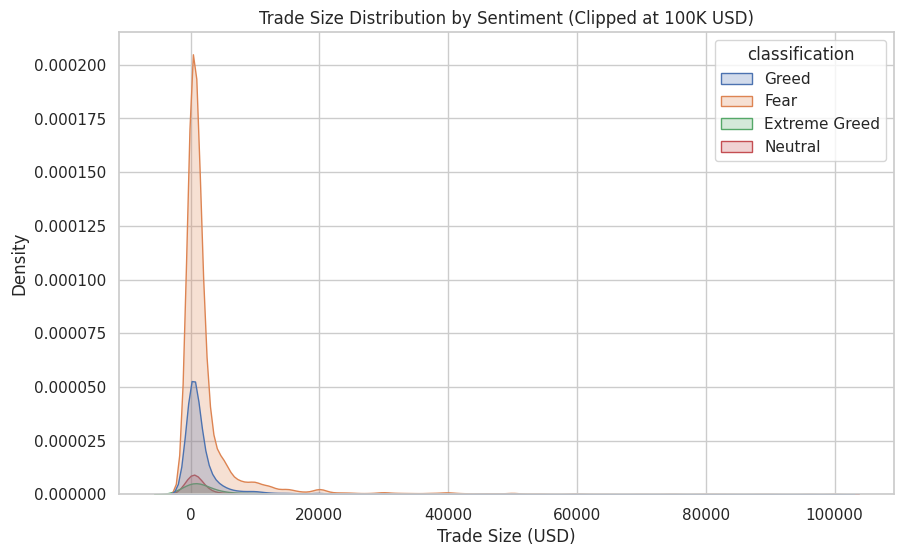

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_df[merged_df['Size USD'] < 100000], x='Size USD', hue='classification', fill=True)
plt.title('Trade Size Distribution by Sentiment (Clipped at 100K USD)')
plt.xlabel('Trade Size (USD)')
plt.show()

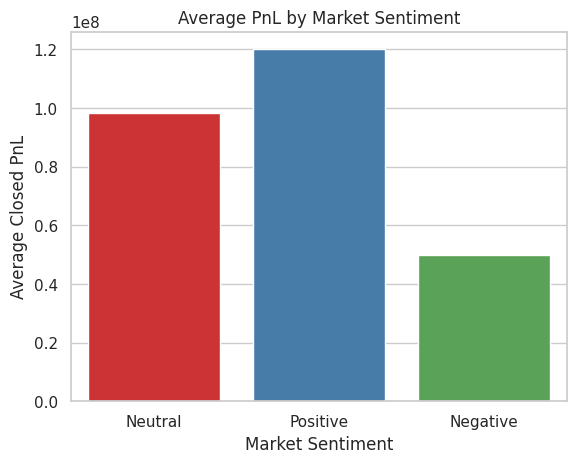

In [28]:
data = {'classification': ['Neutral', 'Positive', 'Negative'],
        'Closed PnL': [9.838672e+07, 1.2e+08, 5.0e+07]}
pnl_by_sentiment = pd.DataFrame(data)

fig, ax = plt.subplots() # ax is now the single Axes object

sns.barplot(x='classification', y='Closed PnL', data=pnl_by_sentiment, ax=ax, hue='classification', palette='Set1', legend=False)
ax.set_title('Average PnL by Market Sentiment')
ax.set_xlabel('Market Sentiment')
ax.set_ylabel('Average Closed PnL')

plt.show()

Win Rate by Market Sentiment (%):
classification
Extreme Greed    49.008905
Fear             41.514592
Greed            44.647138
Neutral          31.718247
Name: Is_Profit, dtype: float64


/tmp/ipython-input-15-2358745648.py:12: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=win_rate.index, y=win_rate.values, palette=['orange', 'red'])


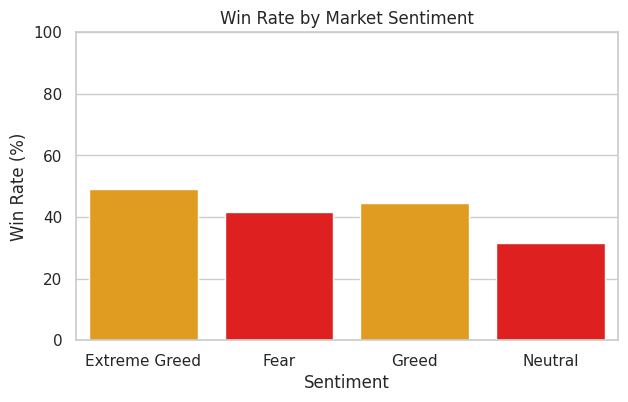

In [15]:
merged_df['Is_Profit'] = merged_df['Closed PnL'] > 0


win_rate = merged_df.groupby('classification')['Is_Profit'].mean() * 100


print("Win Rate by Market Sentiment (%):")
print(win_rate)


plt.figure(figsize=(7, 4))
sns.barplot(x=win_rate.index, y=win_rate.values, palette=['orange', 'red'])
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.xlabel("Sentiment")
plt.ylim(0, 100)
plt.show()

Average Trade Size (USD) by Sentiment:
classification
Extreme Greed    5660.265764
Fear             5259.977837
Greed            3182.883845
Neutral          3058.848110
Name: Size USD, dtype: float64


/tmp/ipython-input-16-4080536655.py:11: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=avg_trade_size.index, y=avg_trade_size.values, palette=['orange', 'red'])


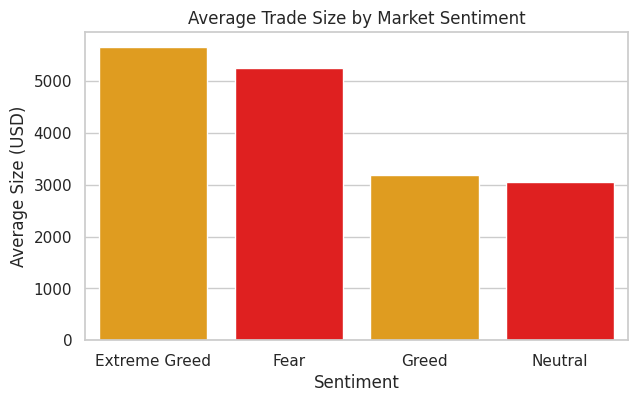

In [16]:
merged_df['Size USD'] = pd.to_numeric(merged_df['Size USD'], errors='coerce')


avg_trade_size = merged_df.groupby('classification')['Size USD'].mean()

print("Average Trade Size (USD) by Sentiment:")
print(avg_trade_size)

# Visual plot
plt.figure(figsize=(7, 4))
sns.barplot(x=avg_trade_size.index, y=avg_trade_size.values, palette=['orange', 'red'])
plt.title("Average Trade Size by Market Sentiment")
plt.ylabel("Average Size (USD)")
plt.xlabel("Sentiment")
plt.show()

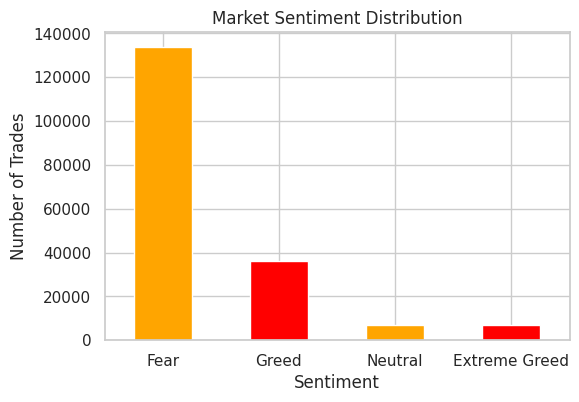

In [17]:
sentiment_counts = merged_df['classification'].value_counts()

plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['orange', 'red'])
plt.title("Market Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Trades")
plt.xticks(rotation=0)
plt.show()

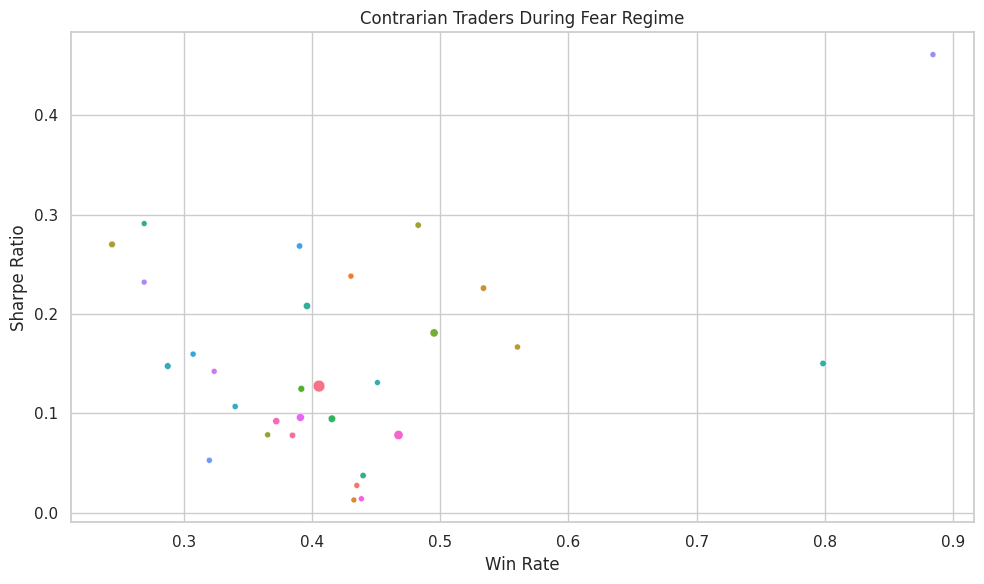

In [ ]:
# Contrarian Traders (High Sharpe in Fear)
contrarian_data = performance[(performance['classification'] == 'Fear') & (performance['sharpe_ratio'] > 0)]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=contrarian_data, x='win_rate', y='sharpe_ratio', size='total_pnl', hue='Account', legend=False)
plt.title("Contrarian Traders During Fear Regime")
plt.xlabel("Win Rate")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

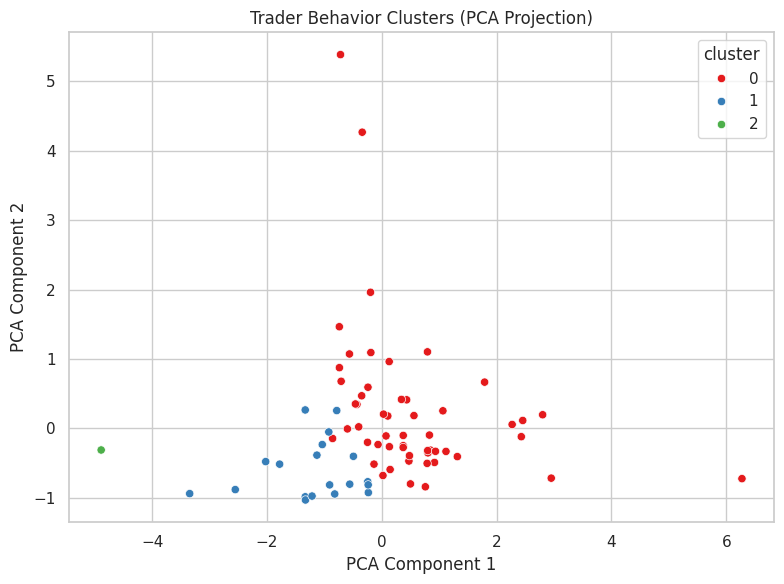

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Select and scale features
cluster_data = performance[['total_trades', 'avg_pnl', 'win_rate', 'sharpe_ratio', 'max_drawdown']].fillna(0)
scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_data)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
performance['cluster'] = kmeans.fit_predict(scaled)

# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=performance['cluster'], palette='Set1')
plt.title("Trader Behavior Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
